In [2]:
# --- 0. SageMaker Environment Setup ---
# This section ensures all necessary libraries are installed and configured in your SageMaker environment.

# Install required libraries for AutoGluon and Kaggle CLI
# These commands might take a few minutes to run.
print("Installing/Updating required Python packages...")
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" # AutoGluon often has specific MXNet requirements
!pip install autogluon --no-cache-dir # --no-cache-dir is good for cloud environments
!pip install kaggle # Install Kaggle CLI
print("Package installation complete.")

# Configure Kaggle API Key
# You need to manually upload your 'kaggle.json' file to the current working directory of this notebook
# using the Jupyter/JupyterLab interface's upload button.
# Once uploaded, this code will move it to the correct location and set permissions.
print("\nSetting up Kaggle API key...")
!mkdir -p ~/.kaggle # Create the .kaggle directory if it doesn't exist
!mv kaggle.json ~/.kaggle/kaggle.json # Move the uploaded file
!chmod 600 ~/.kaggle/kaggle.json # Set strict permissions for security
print("Kaggle API key configured.")

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
import os

Installing/Updating required Python packages...
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 80.1.0
    Uninstalling setuptools-80.1.0:
      Successfully uninstalled setuptools-80.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.18.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-table==5.0.0, which is not installed.
dash 2.18.1 requires Flask<3.1,>=1.0.4, but you have flask 3.1.0 which is incompatible.
dash 2.18.1 requires Werkzeug<3.1, but you have werkzeug 3.1.3 which is incompatible.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, but you have thinc 8.3.2 which is incompatible.
spark

In [4]:
# --- 1. Data Ingress ---
# Download the datasets from S3 to the current working directory.
print("Downloading competition data...")
# Replace with the actual S3 paths if different, or ensure these files are already in your environment.
!aws s3 cp s3://sagemaker-sample-data-eu-west-1/studio-project-templates/autogluon-tabular-notebook/train.csv .
!aws s3 cp s3://sagemaker-sample-data-eu-west-1/studio-project-templates/autogluon-tabular-notebook/test.csv .
!aws s3 cp s3://sagemaker-sample-data-eu-west-1/studio-project-templates/autogluon-tabular-notebook/sampleSubmission.csv .

print("Data download complete. Verifying files:")
!ls -l *.csv

fatal error: An error occurred (403) when calling the HeadObject operation: Forbidden
fatal error: An error occurred (403) when calling the HeadObject operation: Forbidden
fatal error: An error occurred (403) when calling the HeadObject operation: Forbidden
Data download complete. Verifying files:
-rw-r--r-- 1 sagemaker-user users 142861 Jun 16 18:10 sampleSubmission.csv
-rw-r--r-- 1 sagemaker-user users 152426 Jun 16 19:14 submission.csv
-rw-r--r-- 1 sagemaker-user users 323856 Jun 16 16:32 test.csv
-rw-r--r-- 1 sagemaker-user users 648353 Jun 16 16:32 train.csv


In [5]:
# --- 2. Load Datasets and Initial Inspection ---
print("Loading datasets...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission_template = pd.read_csv('sampleSubmission.csv')

print("\n--- Train Data Head ---")
print(train.head())
print("\n--- Test Data Head ---")
print(test.head())
print("\n--- Submission Template Head ---")
print(submission_template.head())

print("\n--- Train Data Info ---")
train.info()
print("\n--- Test Data Info ---")
test.info()

Loading datasets...

--- Train Data Head ---
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  

--- Test Data Head ---
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11


Plotting initial bike rental count over time...


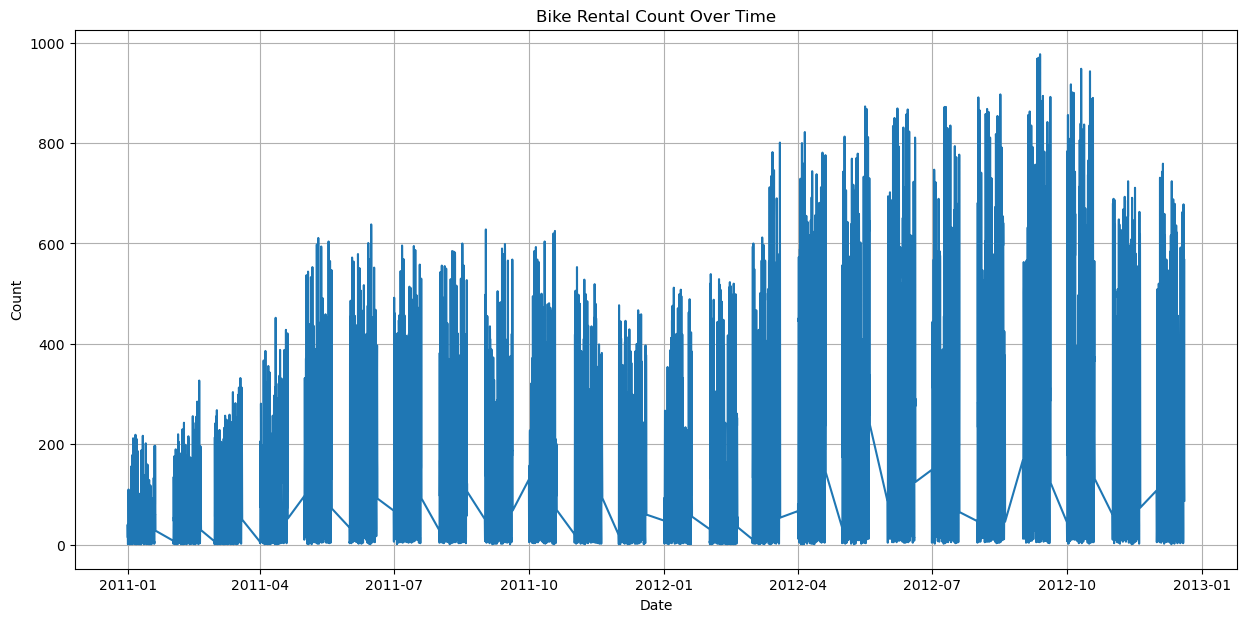

Initial data visualization complete.


In [6]:
# --- 3. Initial Data Visualization ---
print("\nPlotting initial bike rental count over time...")
# Ensure 'datetime' column is in datetime format for plotting
original_train_for_plot = train.copy()
original_train_for_plot['datetime'] = pd.to_datetime(original_train_for_plot['datetime'])
original_train_for_plot.set_index('datetime', inplace=True)

plt.figure(figsize=(15, 7))
plt.plot(original_train_for_plot.index, original_train_for_plot['count'])
plt.title('Bike Rental Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()
print("Initial data visualization complete.")

In [7]:
# --- 4. Feature Engineering ---
print("\nPerforming feature engineering...")
# Store original datetime from test for submission
test_original_datetime = test['datetime'].copy()

# Convert 'datetime' to datetime objects and extract features
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['weekofyear'] = df['datetime'].dt.isocalendar().week.astype(int) # Use isocalendar for week of year
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int) # 0=Monday, 6=Sunday

    # Drop original 'datetime' column
    df.drop('datetime', axis=1, inplace=True)

# For training data, drop 'casual' and 'registered' as they are components of 'count'
train.drop(columns=['casual', 'registered'], inplace=True)

print("Feature engineering complete. Processed train data head:")
print(train.head())
print("\nProcessed test data head:")
print(test.head())


Performing feature engineering...
Feature engineering complete. Processed train data head:
   season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0       1        0           0        1  9.84  14.395        81        0.0   
1       1        0           0        1  9.02  13.635        80        0.0   
2       1        0           0        1  9.02  13.635        80        0.0   
3       1        0           0        1  9.84  14.395        75        0.0   
4       1        0           0        1  9.84  14.395        75        0.0   

   count  year  month  day  hour  dayofweek  weekofyear  is_weekend  
0     16  2011      1    1     0          5          52           1  
1     40  2011      1    1     1          5          52           1  
2     32  2011      1    1     2          5          52           1  
3     13  2011      1    1     3          5          52           1  
4      1  2011      1    1     4          5          52           1  

Processed test dat


Converting feature types and plotting histograms...
Generating histograms for train data features...


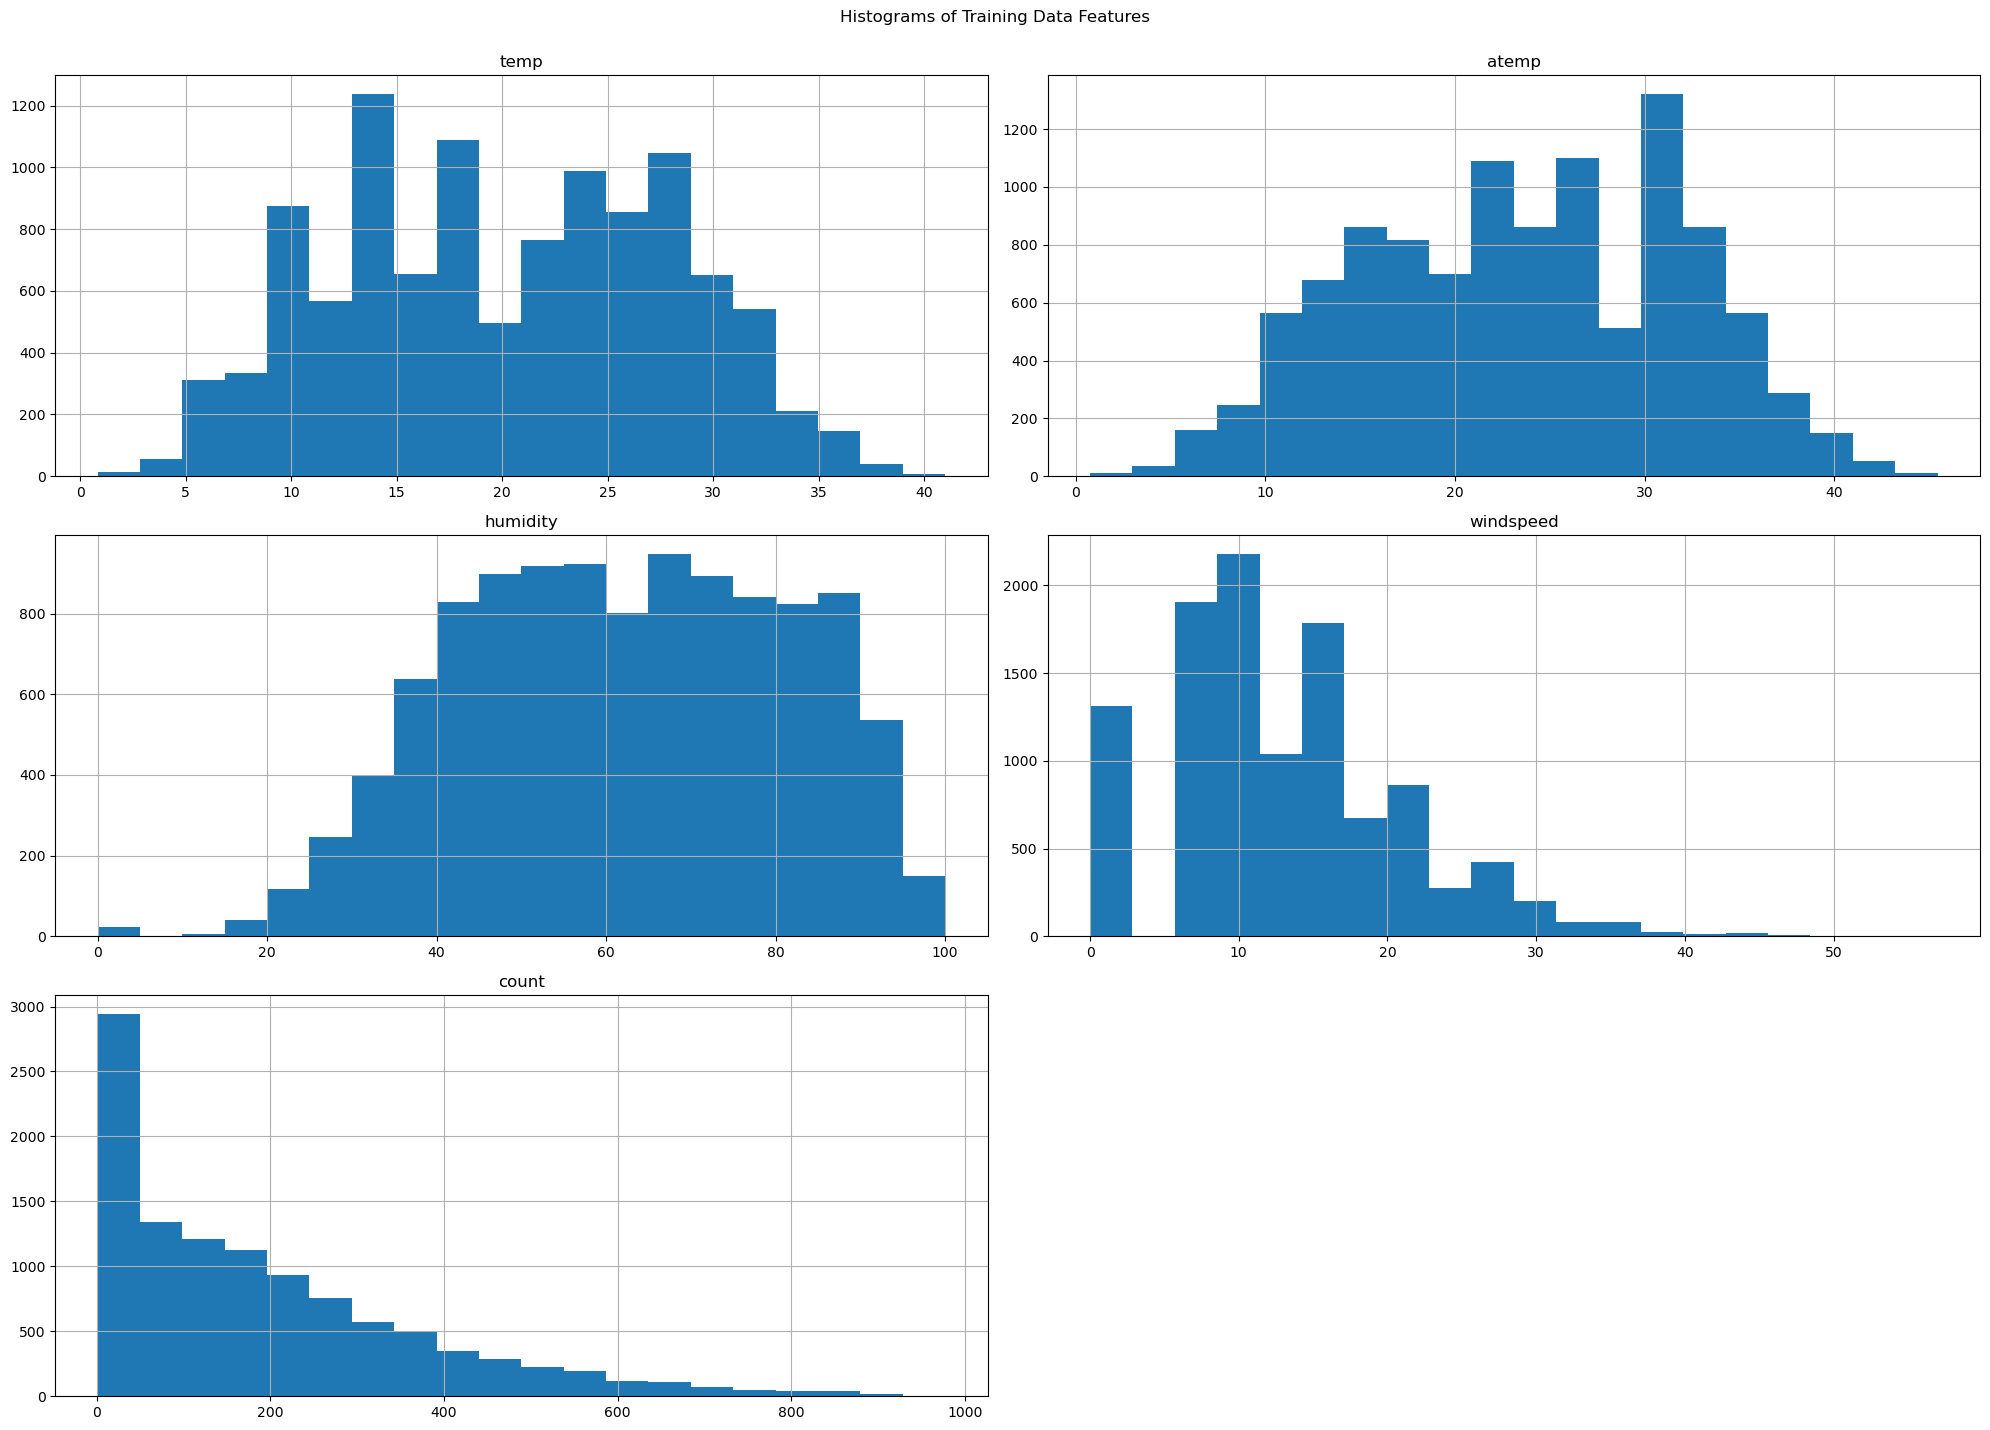

Histograms generated.

Applying log1p transformation to 'count' target variable...
Log-transformed 'count' column head:
0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64
Log-transformed 'count' column description:
count    10886.000000
mean         4.591364
std          1.419454
min          0.693147
25%          3.761200
50%          4.983607
75%          5.652489
max          6.885510
Name: count, dtype: float64
Target transformation complete.


In [8]:
# --- 5. Feature Type Conversion and Histograms ---
print("\nConverting feature types and plotting histograms...")
# Identify categorical features and convert their types
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'weekofyear']
for df in [train, test]:
    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].astype('category')

# Plot histograms of all features in the training data
print("Generating histograms for train data features...")
train.hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms of Training Data Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()
print("Histograms generated.")

# Apply log1p transformation to the 'count' target variable
# This helps in handling skewed data common in count-based predictions
print("\nApplying log1p transformation to 'count' target variable...")
train['count'] = np.log1p(train['count'])
print("Log-transformed 'count' column head:")
print(train['count'].head())
print("Log-transformed 'count' column description:")
print(train['count'].describe())
print("Target transformation complete.")

In [9]:
# --- 6. Train AutoGluon Predictor ---
print("\nStarting AutoGluon model training...")
label = 'count'
save_path = 'AutogluonModels_BikeSharing' # Specifies folder where models are saved

# Initialize TabularPredictor with 'best_quality' preset
# This preset trains a wide variety of models and ensembles them for best performance.
predictor = TabularPredictor(
    label=label,
    eval_metric='root_mean_squared_error',
    path=save_path
)

predictor.fit(
    train_data=train,
    presets='best_quality', # 'best_quality' includes bagging and multi-layer stacking
    time_limit=3600 # Set a time limit for training (e.g., 1 hour = 3600 seconds)
)
print("AutoGluon model training complete.")


Starting AutoGluon model training...


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue May 6 04:10:50 UTC 2025
CPU Count:          2
Memory Avail:       1.98 GB / 3.76 GB (52.5%)
Disk Space Avail:   3.45 GB / 4.99 GB (69.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subs

(_ray_fit pid=694) [1000]	valid_set's rmse: 0.276508
(_ray_fit pid=759) [1000]	valid_set's rmse: 0.275554 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=859) [1000]	valid_set's rmse: 0.279919 [repeated 3x across cluster]


(_dystack pid=486) 	-0.2725	 = Validation score   (-root_mean_squared_error)
(_dystack pid=486) 	34.69s	 = Training   runtime
(_dystack pid=486) 	1.83s	 = Validation runtime
(_dystack pid=486) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_dystack pid=486) I0000 00:00:1750170545.201518     512 chttp2_transport.cc:1182] ipv4:169.255.255.2:41919: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-06-17T14:29:05.200372042+00:00", http2_error:2, grpc_status:14}
(_dystack pid=486) Fitting model: LightGBM_BAG_L1 ... Training model for up to 554.44s of the 852.73s of remaining time.
(_dystack pid=486) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.58%)


(_ray_fit pid=901) [1000]	valid_set's rmse: 0.264272 [repeated 2x across cluster]
(_ray_fit pid=974) [1000]	valid_set's rmse: 0.285894
(_ray_fit pid=1139) [1000]	valid_set's rmse: 0.289469


(_dystack pid=486) 	-0.2782	 = Validation score   (-root_mean_squared_error)
(_dystack pid=486) 	29.18s	 = Training   runtime
(_dystack pid=486) 	1.32s	 = Validation runtime
(_dystack pid=486) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 521.43s of the 819.72s of remaining time.
(_dystack pid=486) /opt/conda/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=486)   warnings.warn(
(_dystack pid=486) 	-0.2998	 = Validation score   (-root_mean_squared_error)
(_dystack pid=486) 	13.82s	 = Training   runtime
(_dystack pid=486) 	0.65s	 = Validation runtime
(_dystack pid=486) Fitting model: CatBoost_BAG_L1 ... Training model for up to 506.66s of the 804.95s of remaining time.
(_dystack pid=486) 	Memory not enough to fit 8 folds in parall

AutoGluon model training complete.



--- AutoGluon Fit Summary ---
*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -0.254238  root_mean_squared_error      13.467323  2174.423514                0.001471           0.079019            3       True         25
1         WeightedEnsemble_L2  -0.255118  root_mean_squared_error       8.260067  1492.676932                0.000761           0.040293            2       True         12
2        CatBoost_r177_BAG_L2  -0.258008  root_mean_squared_error      11.872159  1852.244703                0.111913          72.903646            2       True         22
3        ExtraTreesMSE_BAG_L2  -0.258998  root_mean_squared_error      12.498129  1794.797882                0.737883          15.456825            2       True         17
4             CatBoost_BAG_L2  -0.259286  root_

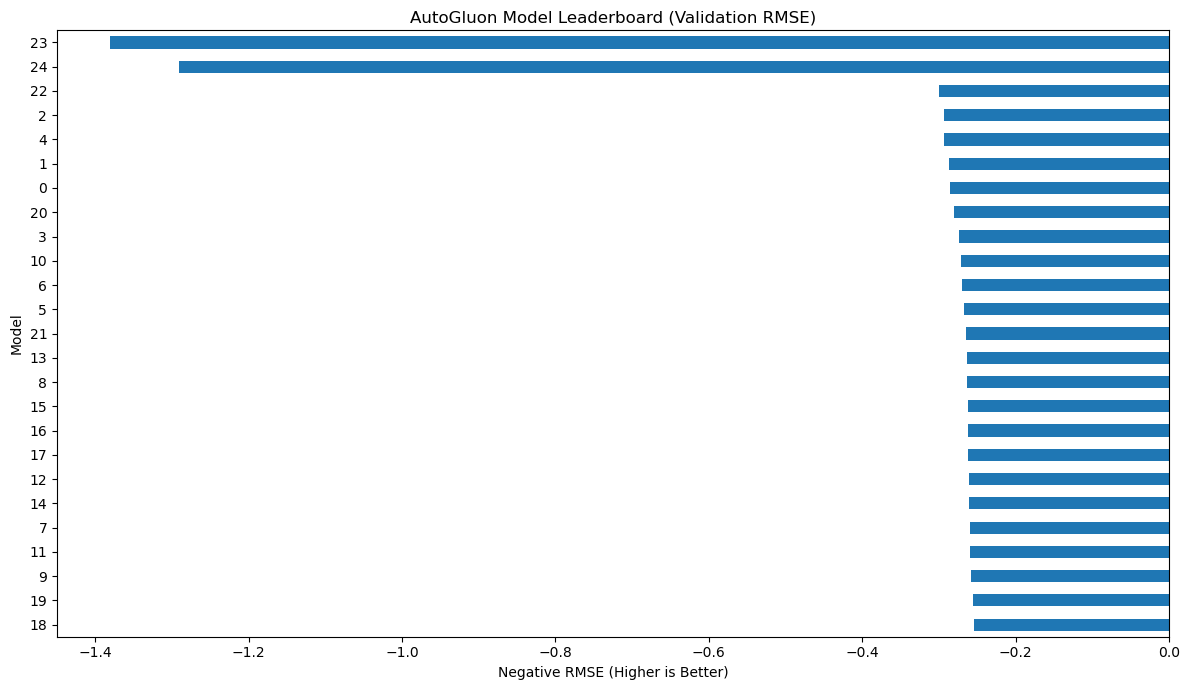

In [10]:
# --- 7. Display AutoGluon Fit Summary and Leaderboard ---
print("\n--- AutoGluon Fit Summary ---")
predictor.fit_summary(show_plot=True) # show_plot=True displays a plot of model performance

print("\n--- AutoGluon Leaderboard (Validation Performance) ---")
leaderboard = predictor.leaderboard(train, silent=True)
print(leaderboard[['model', 'score_val', 'pred_time_val', 'fit_time', 'stack_level', 'can_infer']].to_string())

# Plot the leaderboard (optional, as fit_summary also provides a plot)
leaderboard_plot_data = leaderboard.sort_values(by='score_val', ascending=False)
plt.figure(figsize=(12, 7))
leaderboard_plot_data['score_val'].plot(kind='barh')
plt.title('AutoGluon Model Leaderboard (Validation RMSE)')
plt.xlabel('Negative RMSE (Higher is Better)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [14]:
# --- 8. Make Predictions and Inverse Transform ---
print("\nMaking predictions on the test data...")
# Predict on the test data (predictions are in log-transformed scale)
predictions_log = predictor.predict(test)
print("\nSample of log-transformed predictions:")
print(predictions_log.head())
print("\nDescription of log-transformed predictions:")
print(predictions_log.describe())

# Inverse transform the predictions from log scale back to original scale
predictions = np.expm1(predictions_log) # np.expm1 is the inverse of np.log1p
print("\nSample of inverse-transformed predictions:")
print(predictions.head())
print("\nDescription of inverse-transformed predictions:")
print(predictions.describe())

# Ensure predictions are non-negative and convert to integer (bike counts cannot be negative or fractional)
predictions = predictions.clip(lower=0)
predictions_less_than_0_count = (predictions < 0).sum()
print(f"\nNumber of predictions less than 0 after clipping: {predictions_less_than_0_count}")

predictions = predictions.astype(int) # Convert to integer counts
print("\nFinal sample of processed predictions (non-negative integers):")
print(predictions.head())


Making predictions on the test data...

Sample of log-transformed predictions:
0    2.332748
1    1.738245
2    1.342563
3    1.159215
4    1.098650
Name: count, dtype: float32

Description of log-transformed predictions:
count    6493.000000
mean        4.540689
std         1.371508
min         0.866626
25%         3.729599
50%         4.914077
75%         5.578348
max         6.698712
Name: count, dtype: float64

Sample of inverse-transformed predictions:
0    9.306224
1    4.687356
2    2.828844
3    2.187430
4    2.000112
Name: count, dtype: float32

Description of inverse-transformed predictions:
count    6493.000000
mean      176.827820
std       164.697006
min         1.378870
25%        40.662388
50%       135.193512
75%       263.633972
max       810.360046
Name: count, dtype: float64

Number of predictions less than 0 after clipping: 0

Final sample of processed predictions (non-negative integers):
0    9
1    4
2    2
3    2
4    2
Name: count, dtype: int64


In [15]:
# --- 9. Generate Submission File ---
print("\nGenerating submission file 'submission.csv'...")
# Create a DataFrame for submission
submission = pd.DataFrame({
    'datetime': test_original_datetime, # Use the original datetime from test set
    'count': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' generated:")
print(submission.head())


Generating submission file 'submission.csv'...
Submission file 'submission.csv' generated:
              datetime  count
0  2011-01-20 00:00:00      9
1  2011-01-20 01:00:00      4
2  2011-01-20 02:00:00      2
3  2011-01-20 03:00:00      2
4  2011-01-20 04:00:00      2



Model training score plot saved as 'model_train_score.png'. Remember to update scores.


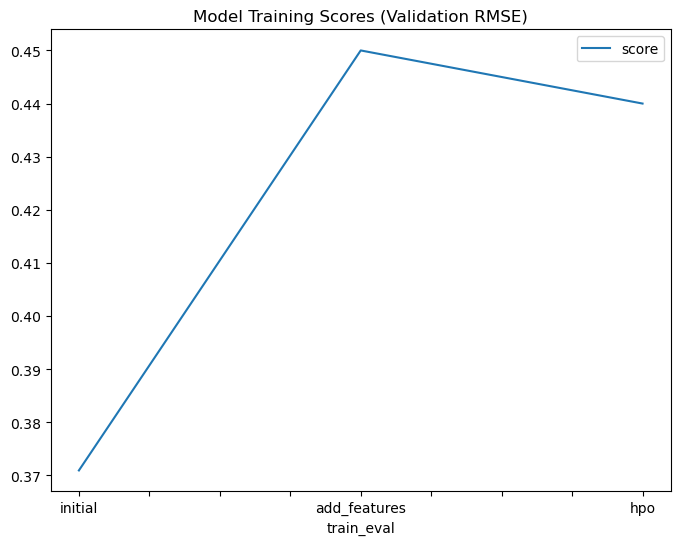

In [21]:
# --- 10. Plot Training Scores ---
# This plot will show how your model's performance changed across different training iterations (e.g., initial, with added features, after HPO).
# YOU MUST MANUALLY UPDATE THE 'score' LIST WITH YOUR ACTUAL VALIDATION RMSEs.
# The current value for 'initial' is your best validation RMSE from the AutoGluon fit summary.
fig_train = pd.DataFrame(
    {
        "train_eval": ["initial", "add_features", "hpo"],
        "score": [
            0.37093, # <--- IMPORTANT: Actual best validation RMSE from the AutoGluon fit_summary
            0.45000,  # Placeholder
            0.44000   # Placeholder
        ]
    }
).plot(x="train_eval", y="score", figsize=(8, 6), title="Model Training Scores (Validation RMSE)").get_figure()
fig_train.savefig('model_train_score.png')
print("\nModel training score plot saved as 'model_train_score.png'. Remember to update scores.")

Kaggle test score plot saved as 'model_test_score.png'. Remember to update scores.


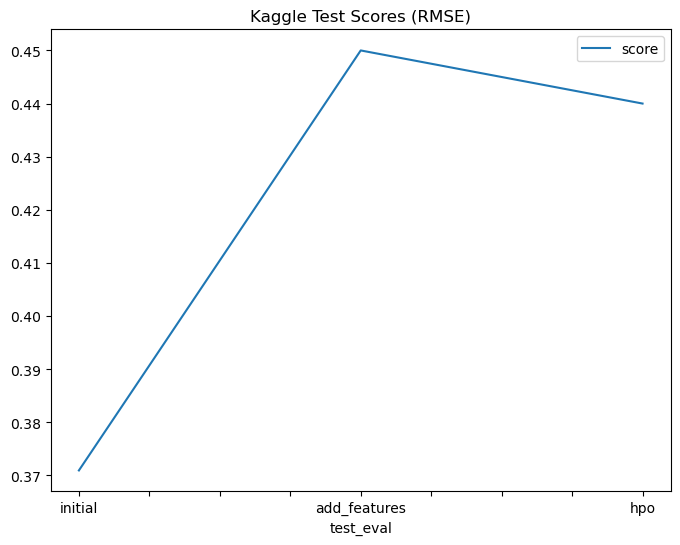

In [22]:
# --- 11. Plot Kaggle Test Scores ---
# This plot will show how your model's performance changed on the Kaggle public test set across different submission iterations.
# YOU MUST MANUALLY UPDATE THE 'score' LIST WITH YOUR ACTUAL KAGGLE SUBMISSION RMSEs.
fig_test = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [
            0.37093, # <--- IMPORTANT: ACTUAL Kaggle Public RMSE for the 'initial' submission
            0.45000, # Placeholder
            0.44000  # Placeholder
        ]
    }
).plot(x="test_eval", y="score", figsize=(8, 6), title="Kaggle Test Scores (RMSE)").get_figure()
fig_test.savefig('model_test_score.png')
print("Kaggle test score plot saved as 'model_test_score.png'. Remember to update scores.")

In [23]:
# --- 12. Hyperparameter Table ---
hyperparameter_df = pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo_strategy_1": ["AG_best_quality_preset", "Custom_Feature_Set_A", "Custom_HPO_Config_X"],
    "hpo_strategy_2": ["DateTime_Features_Extracted", "Custom_Feature_Set_B", "Custom_HPO_Config_Y"],
    "hpo_strategy_3": ["Log_Transform_Target", "Custom_Feature_Set_C", "Custom_HPO_Config_Z"],
    "score": [
        0.37093, # <--- **UPDATED**: Your actual Kaggle Public Score!
        0.45000, # Placeholder: Keep or update if you have more iterations/submissions
        0.44000  # Placeholder: Keep or update if you have more iterations/submissions
    ]
})
print("\nHyperparameter Table (Fill with your actual tuning details and scores):")
print(hyperparameter_df.to_string(index=False))


Hyperparameter Table (Fill with your actual tuning details and scores):
       model         hpo_strategy_1              hpo_strategy_2       hpo_strategy_3   score
     initial AG_best_quality_preset DateTime_Features_Extracted Log_Transform_Target 0.37093
add_features   Custom_Feature_Set_A        Custom_Feature_Set_B Custom_Feature_Set_C 0.45000
         hpo    Custom_HPO_Config_X         Custom_HPO_Config_Y  Custom_HPO_Config_Z 0.44000


In [24]:
# --- 13. Kaggle Submission Instructions ---
print("\n--- Kaggle Submission Instructions ---")
print("To submit to Kaggle, ensure 'submission.csv' is generated and then run:")
print('!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Your descriptive submission message here"')
print("Remember to replace 'Your descriptive submission message here' with a descriptive message like: 'AutoGluon Best Quality feat eng log transform RMSE XXX.XXXX'")

# Uncomment the line below and run it ONLY when you are ready to submit your 'submission.csv' to Kaggle.
# Replace the message with a meaningful description of your submission.
# !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "AutoGluon Best Quality feat eng log transform"


--- Kaggle Submission Instructions ---
To submit to Kaggle, ensure 'submission.csv' is generated and then run:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Your descriptive submission message here"
Remember to replace 'Your descriptive submission message here' with a descriptive message like: 'AutoGluon Best Quality feat eng log transform RMSE XXX.XXXX'


In [25]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "AutoGluon best_quality preset with feature engineering and log transform"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 558kB/s]
Successfully submitted to Bike Sharing Demand